### 一.损失函数

这一节对xgboost回归做介绍，xgboost共实现了5种类型的回归，分别是squarederror、logistic、poisson、gamma、tweedie回归，下面主要对前三种进行推导  

#### squarederror
即损失函数为平方误差的回归模型：  

$$
L(y,y^{hat})=\frac{1}{2}(y-y^{hat})^2
$$  

所以一阶导和二阶导分别为：   

$$
\frac{\partial L(y,y^{hat})}{\partial y^{hat}}=y^{hat}-y\\
\frac{\partial^2 L(y,y^{hat})}{{\partial y^{hat}}^2}=1.0\\
$$  

#### logistic

由于是回归任务，所以y也要套上`sigmoid`函数，损失函数：   

$$
L(y,y^{hat})=(1-sigmoid(y))log(1-sigmoid(y^{hat}))+sigmoid(y)log(sigmoid(y^{hat}))
$$

一阶导和二阶导分别为：   

$$
\frac{\partial L(y,y^{hat})}{\partial y^{hat}}=sigmoid(y^{hat})-sigmoid(y)\\
\frac{\partial^2 L(y,y^{hat})}{{\partial y^{hat}}^2}=sigmoid(y^{hat})(1-sigmoid(y^{hat}))\\
$$   


#### poisson
自然数据很多时候都会服从某种分布，poisson分布便是其中一种，比如某公共汽车站的乘客数，某交通路口单位时间内闯红灯的数量等等，如果我们的目标y恰好也复合poisson分布，那么在构建损失函数时，我们可以考虑将这先验信息融合进去，首先介绍poisson分布，一个随机变量$Y$满足poisson分布时的概率函数可以定义如下：   

$$
P(Y=y)=\frac{\lambda^y}{y!}e^{-\lambda}
$$  

式中，$y$为整数，表示时间发生次数$\lambda$为单位区间(时间)的平均时间数量，poisson分布的均值和方差均为$\lambda$，下面简单看下$\lambda$不同取值时的分布情况

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def poisson(lamb,y_list):
    p=[]
    for y in y_list:
        p.append(np.power(lamb,y)/np.math.factorial(y)*np.exp(-1*lamb))
    return p

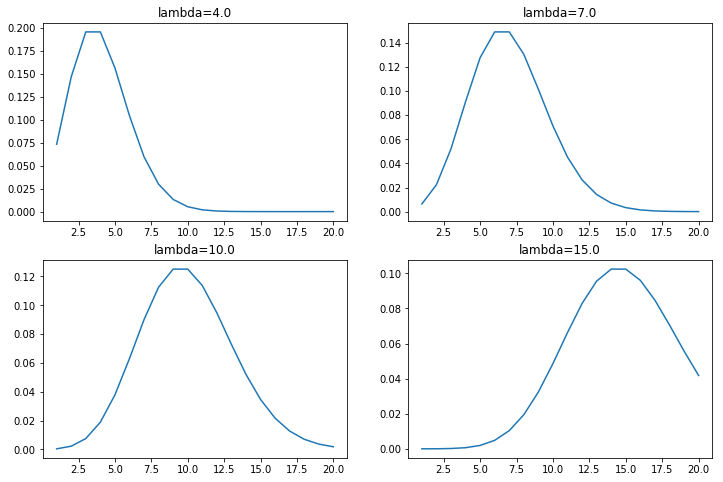

In [2]:
lambs=[4.0,7.0,10.0,15.0]
plt.figure(figsize=(12,8))
y=np.asarray(list(range(1,21))).astype(float)
for index,lamb in enumerate(lambs):
    ax=plt.subplot(2,2,index+1)
    ax.set_title("lambda="+str(lamb))
    plt.plot(y,poisson(lamb,y))

可以发现$\lambda$为$y$取值概率最高的点，而且$\lambda$也是$y$的期望值，所以对输入样本$x$的预测可以转换为对$\lambda$的估计，我们可以假设它们存在这样的关系：  

$$
\lambda=e^{\theta^T x}
$$    

则便是poisson回归，对其求解我们可以使用极大似然估计：  

$$
L(\theta\mid X,Y)=\prod_{i=1}^n\frac{e^{y_i\theta^Tx_i}e^{-e^{\theta^Tx_i}}}{y_i!}
$$   

由于$y_i!$是常数，可以去掉，令$y_i^{hat}=\theta^Tx_i$，并对上式取负对数，转换为求极小值的问题：  

$$
L(y,y^{hat})=\sum_{i=1}^n(e^{y_i^{hat}}-y_iy_i^{hat})
$$  

所以，一阶导和二阶导分别为：   

$$
\frac{\partial L(y,y^{hat})}{\partial y^{hat}}=e^{y^{hat}}-y\\
\frac{\partial^2 L(y,y^{hat})}{{\partial y^{hat}}^2}=e^{y^{hat}}\\
$$   

注意，预测时要对结果取指数

### 二.代码实现
具体流程与gbdt的回归类似，只是每次要计算一阶、二阶导数信息，同时基学习器要替换为上一节的xgboost回归树

In [3]:
import os
os.chdir('../')
from ml_models.ensemble import XGBoostBaseTree
from ml_models import utils
import copy
import numpy as np

"""
xgboost回归树的实现，封装到ml_models.ensemble
"""

class XGBoostRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0, loss='squarederror'):
        """
        :param base_estimator: 基学习器
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        :param loss:损失函数，支持squarederror、logistic、poisson
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = XGBoostBaseTree()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)
        self.loss = loss

    def _get_gradient_hess(self, y, y_pred):
        """
        获取一阶、二阶导数信息
        :param y:真实值
        :param y_pred:预测值
        :return:
        """
        if self.loss == 'squarederror':
            return y_pred - y, np.ones_like(y)
        elif self.loss == 'logistic':
            return utils.sigmoid(y_pred) - utils.sigmoid(y), utils.sigmoid(y_pred) * (1 - utils.sigmoid(y_pred))
        elif self.loss == 'poisson':
            return np.exp(y_pred) - y, np.exp(y_pred)

    def fit(self, x, y):
        y_pred = np.zeros_like(y)
        g, h = self._get_gradient_hess(y, y_pred)
        for index in range(0, self.n_estimators):
            self.base_estimator[index].fit(x, g, h)
            y_pred += self.base_estimator[index].predict(x) * self.learning_rate
            g, h = self._get_gradient_hess(y, y_pred)

    def predict(self, x):
        rst_np = np.sum(
            [self.base_estimator[0].predict(x)] +
            [self.learning_rate * self.base_estimator[i].predict(x) for i in
             range(1, self.n_estimators - 1)] +
            [self.base_estimator[self.n_estimators - 1].predict(x)]
            , axis=0)
        if self.loss == "poisson":
            return np.exp(rst_np)
        else:
            return rst_np

In [4]:
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100)  # 添加噪声
data = data.reshape((-1, 1))

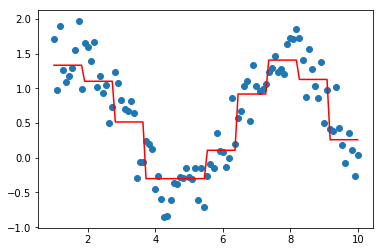

In [5]:
model = XGBoostRegressor(loss='logistic')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

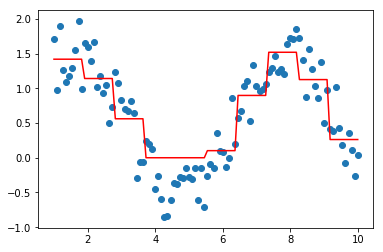

In [6]:
model = XGBoostRegressor(loss='poisson')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

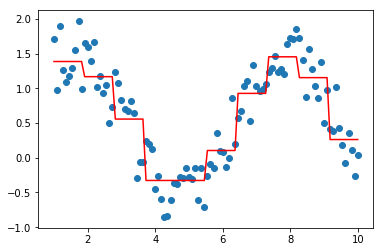

In [7]:
model = XGBoostRegressor(loss='squarederror')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()